In [1]:
import pandas as pd
import time
import tweepy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from nltk.stem.snowball import SnowballStemmer
from tabulate import tabulate

## Scrapping Data From Twitter

#### NOTE:
Please replace the folowing with the corresponding actual keys and tokens.
- consumer_key
- consumer_secret
- access_token
- access_token_secret

In [ ]:
consumer_key = '****'
consumer_secret = '****'
access_token = '****'
access_token_secret = '****'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

tweet_list = []

try:
    start_date = "2020-07-12"  # Specify the start date here
    end_date = "2023-07-13"  # Specify the end date here

    # Create a Cursor instance with the desired parameters
    cursor = tweepy.Cursor(api.user_timeline, screen_name='WilliamsRuto', tweet_mode='extended')

    for tweet in cursor.items():
        if start_date <= tweet.created_at.date().strftime("%Y-%m-%d") <= end_date:
            print("Tweet ID:", tweet.id)
            print("Text:", tweet.full_text)
            print("Created at:", tweet.created_at)
            print("User:", tweet.user.screen_name)
            print("User Location:", tweet.user.location)
            print("User Followers Count:", tweet.user.followers_count)
            print("Like count:", tweet.favorite_count)
            print("Retweet count:", tweet.retweet_count)
            print("Bookmarks count:", tweet.user.favourites_count)

            # Get all replies to the tweet
            retries = 3
            while retries > 0:
                try:
                    replies = tweepy.Cursor(api.search_tweets, q='to:' + tweet.user.screen_name, since_id=tweet.id_str,
                                            tweet_mode='extended').items()

                    reply_count = 0
                    for reply in replies:
                        if reply.in_reply_to_status_id_str == tweet.id_str:
                            reply_count += 1

                    break
                except tweepy.TooManyRequests as e:
                    print("Rate limit exceeded. Waiting for 15 minutes.")
                    time.sleep(15 * 60)  # Wait for 15 minutes
                    retries -= 1
                except Exception as e:
                    print("An error occurred:", str(e))
                    retries = 0  # Exit the loop and proceed with other tweets

            print("Reply count:", reply_count)
            print("------")

            required_tweet = {
                "Tweet ID": tweet.id,
                "Text": tweet.full_text,
                "Created at": tweet.created_at,
                "User": tweet.user.screen_name,
                "User Location": tweet.user.location,
                "User Followers Count": tweet.user.followers_count,
                "Like count": tweet.favorite_count,
                "Retweet count": tweet.retweet_count,
                "Reply count": reply_count,
                "Bookmarks count": tweet.user.favourites_count,
            }
            tweet_list.append(required_tweet)

except tweepy.TooManyRequests as e:
    print("Rate limit exceeded. Please try again later.")
except Exception as e:
    print("An error occurred:", str(e))

df = pd.DataFrame(tweet_list)

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('Data/Williams_Ruto_tweet_data_from_15_Aug_2022.csv', index=False)

## Analysis & Visualization

0       Present were Deputy President @rigathi, Cabine...
1       During the 8th Annual Dairy Farmers Field Day ...
2       We have removed tax on livestock feeds and are...
3       Leveraging value addition and agro-processing ...
4       During the International Labour Organisation's...
                              ...                        
1649    I will work for all Kenyans. We will go out of...
1650    Thank you Kenya for the biggest honour of my l...
1651    He has made the way. God is great. Thank you h...
1652    “'For I know the plans I have for you,' declar...
1653    In that day you will say: “Give praise to the ...
Name: Text, Length: 1654, dtype: object


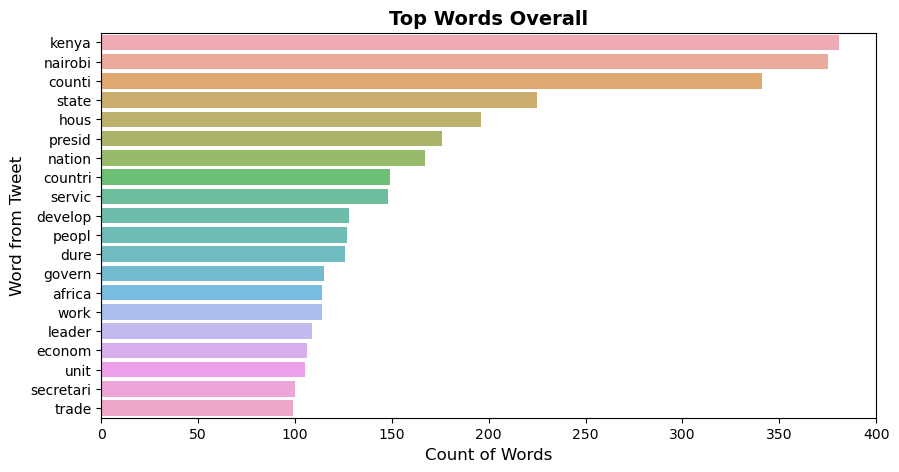

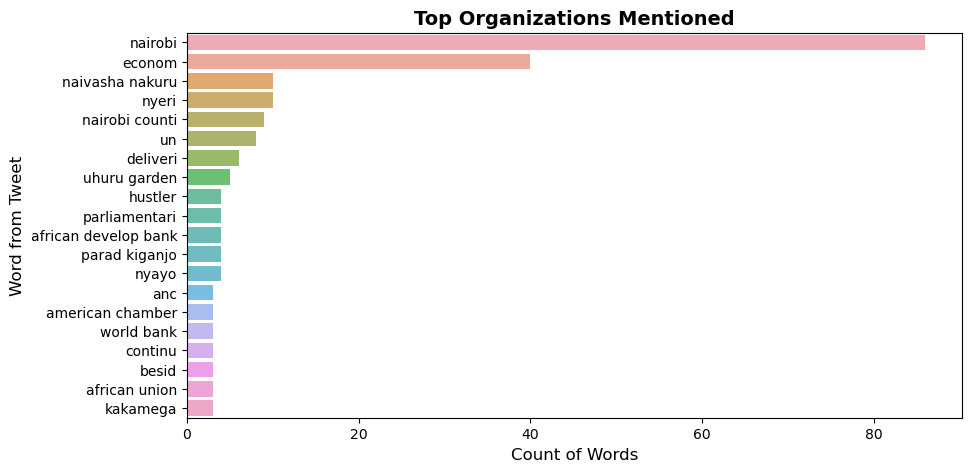

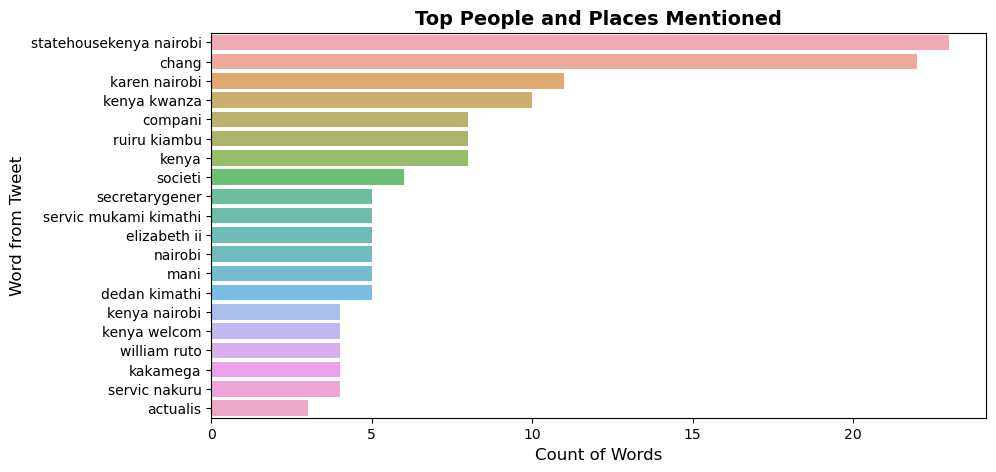

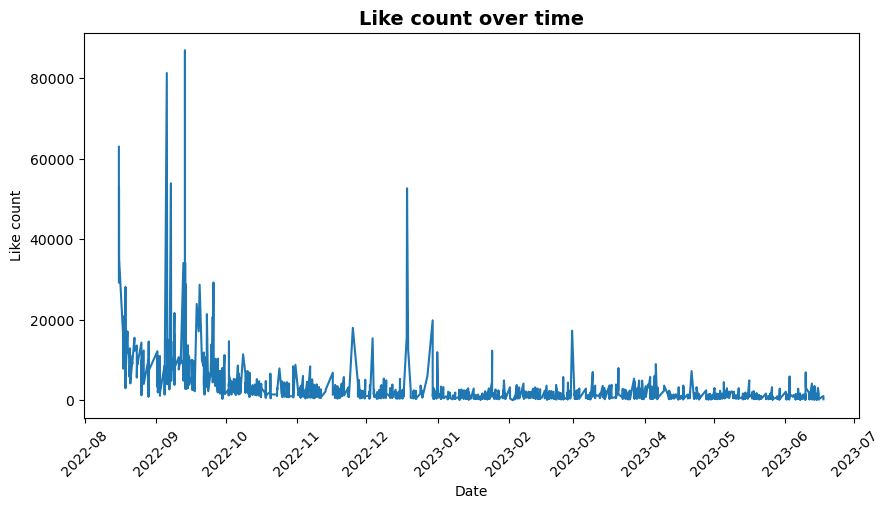

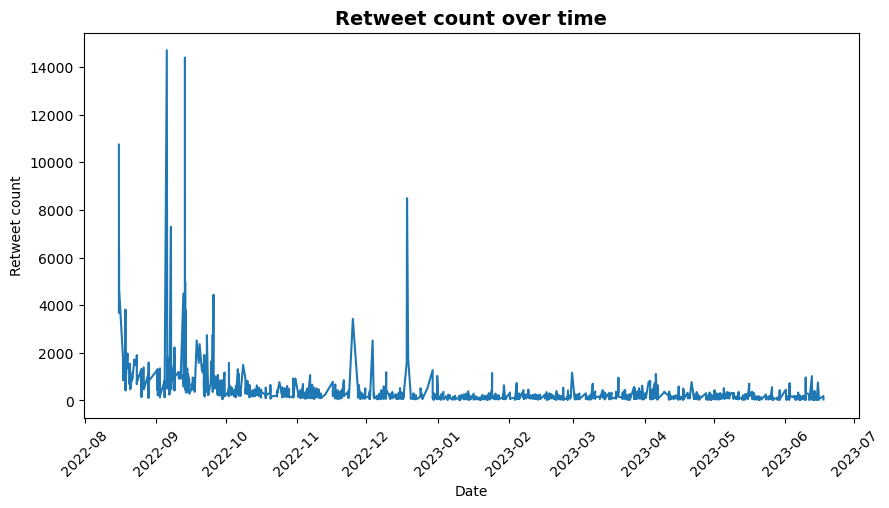

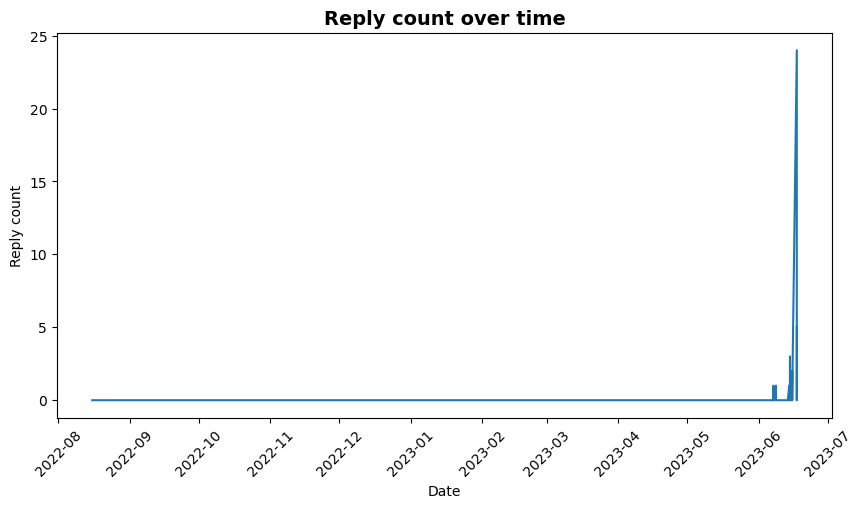

Engagement Rate over time
+----+--------+------------+--------------+-----------------+---------------+------------------------+-----------------------+
|    |   Year |   Tweet ID |   Like count |   Retweet count |   Reply count |   User Followers Count | Engagement Rate (%)   |
+====+========+============+==============+=================+===============+========================+=======================+
|  0 |   2022 |        629 |      3239791 |          405166 |             0 |            5.98237e+06 | 60.93%                |
+----+--------+------------+--------------+-----------------+---------------+------------------------+-----------------------+
|  1 |   2023 |       1025 |      1059957 |          143098 |            45 |            5.98215e+06 | 20.11%                |
+----+--------+------------+--------------+-----------------+---------------+------------------------+-----------------------+


In [2]:
import matplotlib.pyplot as plt

# Load the English language model in SpaCy
nlp = en_core_web_sm.load()

# Read the CSV file
df = pd.read_csv('Data/Williams_Ruto_tweet_data_from_15_Aug_2022.csv')

# Display only the first 5 rows and the last 5 rows
df.head()
df.tail()

# Display only the text column
tweet_text = df["Text"]
print(tweet_text)

# Split the text into individual words
lines = []
for text in tweet_text:
    words = text.split()
    lines.extend(words)

# Clean the lines by removing non-alphanumeric characters
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

# Remove empty strings from the lines
lines = [word for word in lines if word != '']

# Stem the words to their root
s_stemmer = SnowballStemmer(language='english')
stem = [s_stemmer.stem(word) for word in lines]

# Remove stop words from the stemmed words
stem2 = [word for word in stem if word not in nlp.Defaults.stop_words]

# Create a DataFrame with the stemmed words and their frequencies
df_stem = pd.DataFrame(stem2)
word_counts = df_stem[0].value_counts()

# Plot the top 20 words overall
plt.figure(figsize=(10, 5))
plt.title('Top Words Overall', fontsize=14, fontweight='bold', loc='center')
sns.barplot(x=word_counts[:20].values, y=word_counts[:20].index, alpha=0.8)
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

# Analyze organizations mentioned
stem2_text = " ".join(stem2)
stem2_doc = nlp(stem2_text)

org_entities = [(X.text, X.label_) for X in stem2_doc.ents if X.label_ == 'ORG']
df_org = pd.DataFrame(org_entities, columns=['Word', 'Entity'])
org_counts = df_org['Word'].value_counts()

# Plot the top organizations mentioned
plt.figure(figsize=(10, 5))
plt.title('Top Organizations Mentioned', fontsize=14, fontweight='bold', loc='center')
sns.barplot(x=org_counts[:20].values, y=org_counts[:20].index, alpha=0.8)
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

# Analyze people and places mentioned
person_entities = [(X.text, X.label_) for X in stem2_doc.ents if X.label_ == 'PERSON']
df_person = pd.DataFrame(person_entities, columns=['Word', 'Entity'])
person_counts = df_person['Word'].value_counts()

# Plot the top people and places mentioned
plt.figure(figsize=(10, 5))
plt.title('Top People and Places Mentioned', fontsize=14, fontweight='bold', loc='center')
sns.barplot(x=person_counts[:20].values.flatten(), y=person_counts[:20].index, alpha=0.8)
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

# Plot engagement metrics over time
df['Created at'] = pd.to_datetime(df['Created at'])

# Plot the 'Like count' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Created at'], df['Like count'])
plt.xlabel('Date')
plt.ylabel('Like count')
plt.title('Like count over time', fontsize=14, fontweight='bold', loc='center')
plt.xticks(rotation=45)
plt.show()

# Plot the 'Retweet count' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Created at'], df['Retweet count'])
plt.xlabel('Date')
plt.ylabel('Retweet count')
plt.title('Retweet count over time', fontsize=14, fontweight='bold', loc='center')
plt.xticks(rotation=45)
plt.show()

# Plot the 'Reply count' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Created at'], df['Reply count'])
plt.xlabel('Date')
plt.ylabel('Reply count')
plt.title('Reply count over time', fontsize=14, fontweight='bold', loc='center')
plt.xticks(rotation=45)
plt.show()

# Calculate yearly statistics
print("Engagement Rate over time")
df['Year'] = pd.to_datetime(df['Created at']).dt.year
yearly_stats = df.groupby('Year').agg({
    'Tweet ID': 'count',
    'Like count': 'sum',
    'Retweet count': 'sum',
    'Reply count': 'sum',
    'User Followers Count': 'mean'
}).reset_index()
yearly_stats['Engagement Rate (%)'] = (yearly_stats['Like count'] + yearly_stats['Retweet count'] + yearly_stats['Reply count']) / yearly_stats['User Followers Count'] * 100

# Format the Engagement Rate column to include the percentage symbol
yearly_stats['Engagement Rate (%)'] = yearly_stats['Engagement Rate (%)'].map('{:.2f}%'.format)

# Create a table from the yearly statistics DataFrame
table = tabulate(yearly_stats, headers='keys', tablefmt='grid')

# Print the table
print(table)